In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import scipy.stats as stats
from tqdm import tqdm

# Parameters
sample_rate = 16000
n_mfcc = 20
max_files = 20000

# Paths
base_path = "/your/audio/data/path"
class_folders = {"real": 1, "fake": 0}  # Label 1 for real, 0 for fake

# Output
data = []

for cls, label in class_folders.items():
    folder = os.path.join(base_path, cls)
    files = [f for f in os.listdir(folder) if f.lower().endswith(".flac")][:max_files]

    for fname in tqdm(files, desc=f"Processing {cls}"):
        try:
            y, sr = librosa.load(os.path.join(folder, fname), sr=sample_rate)

            # Normalize
            y = y / np.max(np.abs(y)) if np.max(np.abs(y)) > 0 else y

            # MFCC
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            mfcc_mean = np.mean(mfcc, axis=1)
            mfcc_std = np.std(mfcc, axis=1)

            # Delta MFCC
            delta_mfcc = librosa.feature.delta(mfcc)
            delta_mean = np.mean(delta_mfcc, axis=1)

            # ZCR
            zcr = librosa.feature.zero_crossing_rate(y)[0]
            zcr_stats = [
                np.mean(zcr), np.std(zcr), np.min(zcr),
                np.max(zcr), stats.skew(zcr), stats.kurtosis(zcr)
            ]

            # Spectral features
            spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
            spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
            spec_flat = librosa.feature.spectral_flatness(y=y)[0]

            spectral_features = []
            for f in [spec_centroid, spec_bw, spec_rolloff, spec_flat]:
                spectral_features.extend([np.mean(f), np.std(f)])

            # Combine all features
            features = [fname] + mfcc_mean.tolist() + mfcc_std.tolist() + delta_mean.tolist() + zcr_stats + spectral_features + [label]
            data.append(features)

        except Exception as e:
            print(f"Error in {fname}: {e}")

# Columns
mfcc_cols = [f"mfcc_mean_{i+1}" for i in range(n_mfcc)] + [f"mfcc_std_{i+1}" for i in range(n_mfcc)]
delta_cols = [f"delta_mean_{i+1}" for i in range(n_mfcc)]
zcr_cols = ["zcr_mean", "zcr_std", "zcr_min", "zcr_max", "zcr_skew", "zcr_kurtosis"]
spec_cols = [
    "centroid_mean", "centroid_std", "bandwidth_mean", "bandwidth_std",
    "rolloff_mean", "rolloff_std", "flatness_mean", "flatness_std"
]

columns = ["filename"] + mfcc_cols + delta_cols + zcr_cols + spec_cols + ["label"]

# Save to Excel
df = pd.DataFrame(data, columns=columns)
df.to_excel("audio_features_40000.xlsx", index=False)
print("✅ Features extracted and saved to audio_features_40000.xlsx")

Padded features from 74 to 128 and reshaped to (40000, 16, 8, 1)
Epoch 1/60
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.5991 - loss: 0.6567 - val_accuracy: 0.7186 - val_loss: 0.5462 - learning_rate: 1.0000e-04
Epoch 2/60
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7057 - loss: 0.5658 - val_accuracy: 0.7639 - val_loss: 0.4949 - learning_rate: 1.0000e-04
Epoch 3/60
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7340 - loss: 0.5303 - val_accuracy: 0.7830 - val_loss: 0.4551 - learning_rate: 1.0000e-04
Epoch 4/60
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7560 - loss: 0.5012 - val_accuracy: 0.8029 - val_loss: 0.4274 - learning_rate: 1.0000e-04
Epoch 5/60
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7720 - loss: 0.4761 - val_accuracy: 0.8165 - val_loss: 0.4029 - learning_rate: 1.0000e-04
Epoch 6/60
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7825 - loss: 0.4603 - val_accuracy: 0.8219 - val_loss: 0.3899 - learning_r

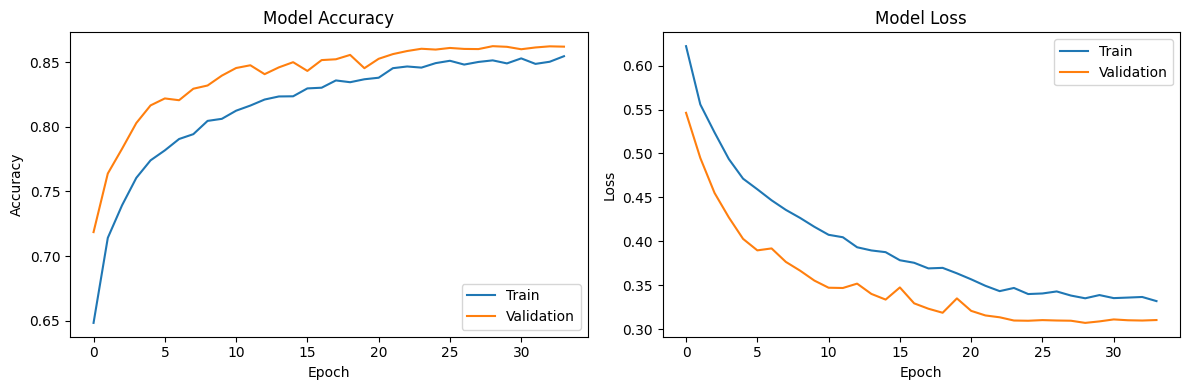

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.81      0.85      3986
           1       0.83      0.92      0.87      4014

    accuracy                           0.86      8000
   macro avg       0.87      0.86      0.86      8000
weighted avg       0.87      0.86      0.86      8000



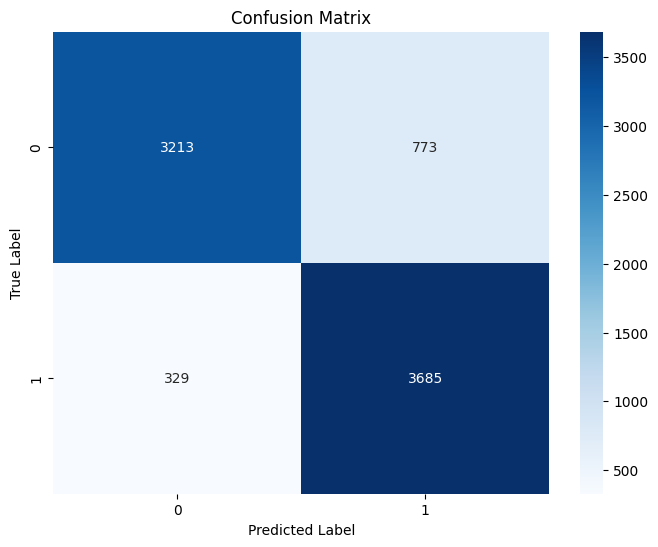

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load dataset
df = pd.read_excel('/content/audio_features_40000.xlsx')
last_column_name = df.columns[-1]
X = df.drop(columns=[last_column_name, 'filename'])
y = df[last_column_name].replace(-1, 0)

# Encode target
num_classes = len(y.unique())
y_encoded = to_categorical(y, num_classes=num_classes)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN input (without PCA)
# Check the number of features after scaling
num_features = X_scaled.shape[1]
target_shape = (16, 8) # Desired shape for CNN input
required_features = target_shape[0] * target_shape[1] # 128

# Decide how to handle the feature count relative to the target shape
if num_features < required_features:
    # If original features are less than target shape product, pad the data
    padding_size = required_features - num_features
    X_padded = np.pad(X_scaled, ((0, 0), (0, padding_size)), mode='constant', constant_values=0)
    X_reshaped = X_padded.reshape(-1, target_shape[0], target_shape[1], 1)
    print(f"Padded features from {num_features} to {required_features} and reshaped to {X_reshaped.shape}")
elif num_features > required_features:
    X_truncated = X_scaled[:, :required_features]
    X_reshaped = X_truncated.reshape(-1, target_shape[0], target_shape[1], 1)
    print(f"Truncated features from {num_features} to {required_features} and reshaped to {X_reshaped.shape}")
else: # num_features == required_features
     X_reshaped = X_scaled.reshape(-1, target_shape[0], target_shape[1], 1)
     print(f"Reshaped {num_features} features to {X_reshaped.shape}")


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

# Squeeze-and-Excitation Block
def se_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# CNN Model with SE blocks - Ensure input shape matches the reshaped data
inputs = Input(shape=X_train.shape[1:]) # Use the shape of the training data
x = Conv2D(32, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = se_block(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

x = Conv2D(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = se_block(x)
x = MaxPooling2D()(x)
x = Dropout(0.4)(x)

x = Conv2D(128, 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = se_block(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
]

# Train model
history = model.fit(X_train, y_train, epochs=60, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=callbacks)

# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Testing & Classification Report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import keras
from google.colab import drive
drive.mount('/content/drive')

    # Save to a folder in your Google Drive
model.save('/content/drive/My Drive/my_model.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
